In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load dataset with correct separator
df = pd.read_csv('Stars.csv', sep=';')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (240, 7)


,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,Red Dwarf


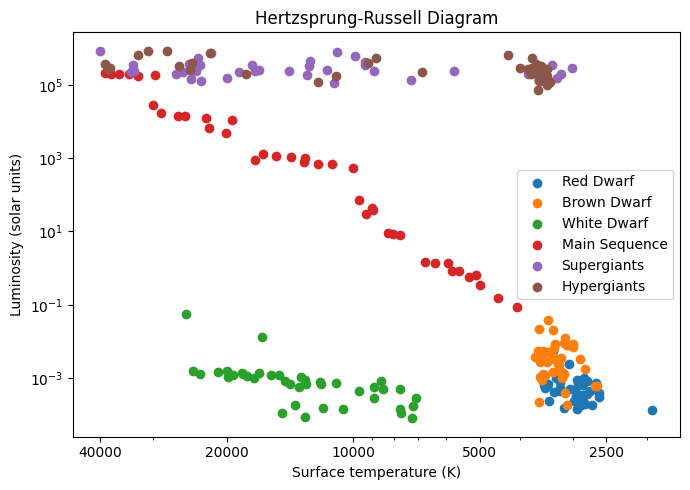

In [4]:
# Extract features and labels
temperatures = df["Temperature"]
radii = df["R"]
luminosities = df["L"]
types = df["Type"]

# Define a colormap
unique_types = types.unique()
cmap = plt.get_cmap("tab10")
colors = {t: cmap(i) for i, t in enumerate(unique_types)}

# Create the H-R diagram with a logarithmic temperature axis
plt.figure(figsize=(7, 5))
for t in unique_types:
    mask = types == t
    plt.scatter(temperatures[mask], luminosities[mask], label=t, color=colors[t])

ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
ax.invert_xaxis()  # Invert x-axis: temperature decreases to the right
ticks = [40000, 20000, 10000, 5000, 2500]
ax.set_xticks(ticks)
ax.set_xticklabels([str(t) for t in ticks])

plt.xlabel("Surface temperature (K)")
plt.ylabel("Luminosity (solar units)")
plt.title("Hertzsprung-Russell Diagram")
plt.legend()
plt.tight_layout()
plt.savefig("HR diagram.pdf", bbox_inches="tight")
plt.show()

In [5]:
# Separate features and target
X = df.drop("Type", axis=1)
y = df["Type"]

# Encode categorical features if any (Color, Spectral_Class)
for col in ["Color", "Spectral_Class"]:
    X[col] = LabelEncoder().fit_transform(X[col])

# Encode target labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

In [6]:
# Initialize models
clf_mlp = MLPClassifier(hidden_layer_sizes=(64, 64), batch_size=32, max_iter=50, random_state=42)
clf_svm = SVC(kernel="rbf", probability=True, random_state=42)
clf_dt = DecisionTreeClassifier(random_state=42)

# Train models
clf_mlp.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)
clf_dt.fit(X_train, y_train)

c:\Users\tatha\.conda\envs\MastersThesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


DecisionTreeClassifier(random_state=42)

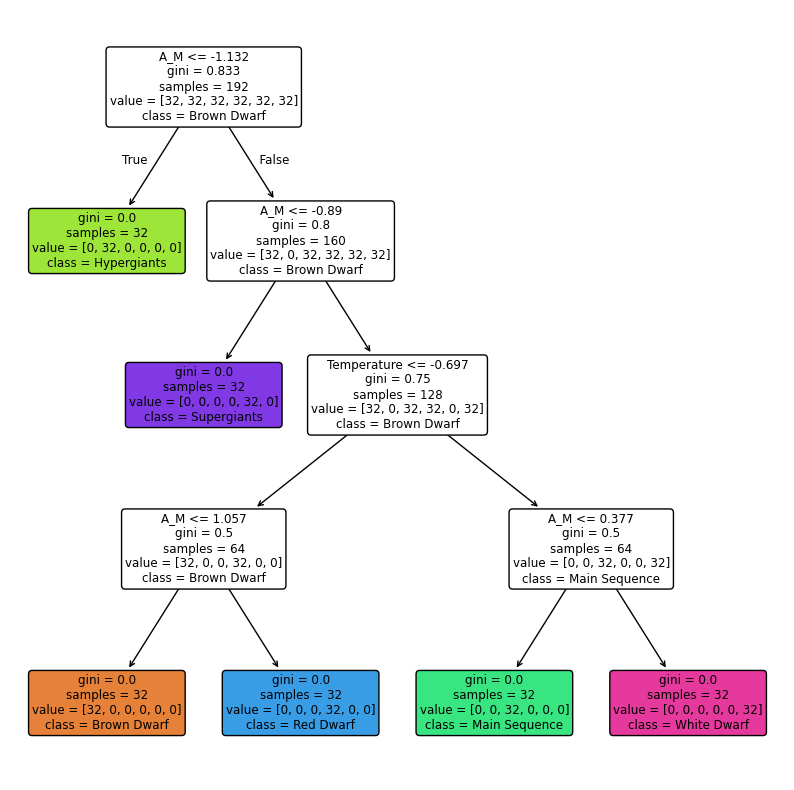

In [7]:
from sklearn import tree
features = ["Temperature", "L", "R", "A_M", "Color_enc", "Spec_enc"]
classes = le.classes_
fig, ax = plt.subplots(figsize=(10,10))
tree.plot_tree(clf_dt, label="all", class_names=classes, feature_names=features, filled=True, rounded=True, ax=ax);
# plt.tight_layout()
plt.savefig("decision_tree.pdf", bbox_inches="tight")
plt.show()

In [8]:
# Prepare results
models = {"Multilayer Perceptron": clf_mlp, "Support Vector Machine": clf_svm, "Decision Tree": clf_dt}
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append(
        {
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-score": f1_score(y_test, y_pred, average="weighted"),
        }
    )

# Display comparison table
results_df = pd.DataFrame(results)
print(results_df)

                    Model  Accuracy  Precision    Recall  F1-score
0   Multilayer Perceptron  1.000000   1.000000  1.000000  1.000000
1  Support Vector Machine  0.958333   0.966667  0.958333  0.957672
2           Decision Tree  1.000000   1.000000  1.000000  1.000000


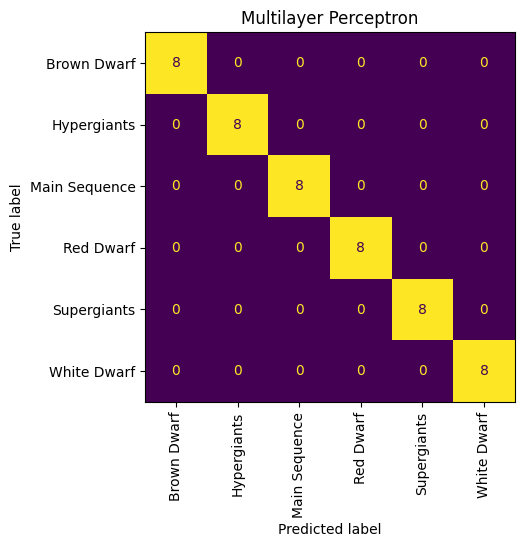

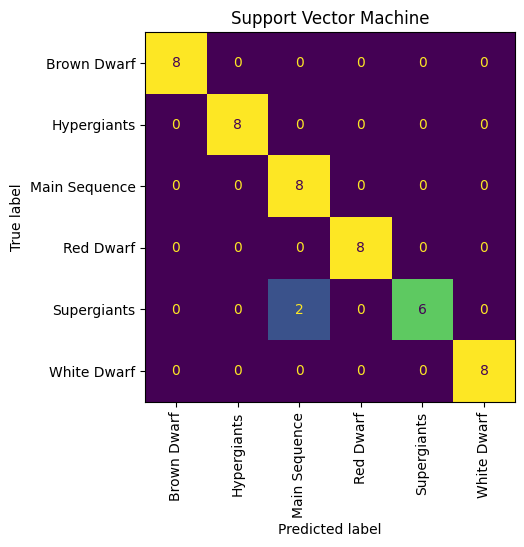

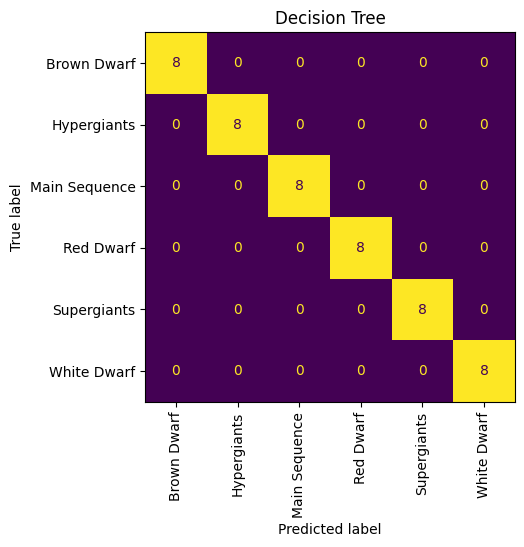

In [9]:
# Print confusion matrices and classification reports
with open("metrics.txt", "w") as metrics_file:
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"{name} Confusion Matrix:\n", file=metrics_file)
        cm = confusion_matrix(y_test, y_pred)
        print(cm, file=metrics_file)
        print(f"\n{name} Classification Report:\n", file=metrics_file)
        print(classification_report(y_test, y_pred, target_names=le.classes_), file=metrics_file)

        fig, ax = plt.subplots()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(xticks_rotation="vertical", colorbar=False, ax=ax)
        plt.title(f"{name}")
        plt.savefig(f"{name}_cm.pdf", bbox_inches="tight")
        plt.show()

In [10]:
clf_mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 32,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (64, 64),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 50,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [11]:
clf_svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [12]:
clf_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

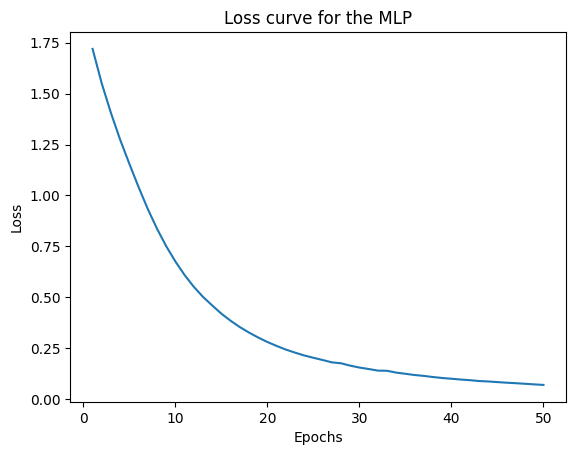

In [16]:
loss_curve = clf_mlp.loss_curve_
epochs = list(range(1, 51))

plt.plot(epochs, loss_curve)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss curve for the MLP")
plt.savefig("loss_curve.pdf", bbox_inches="tight")

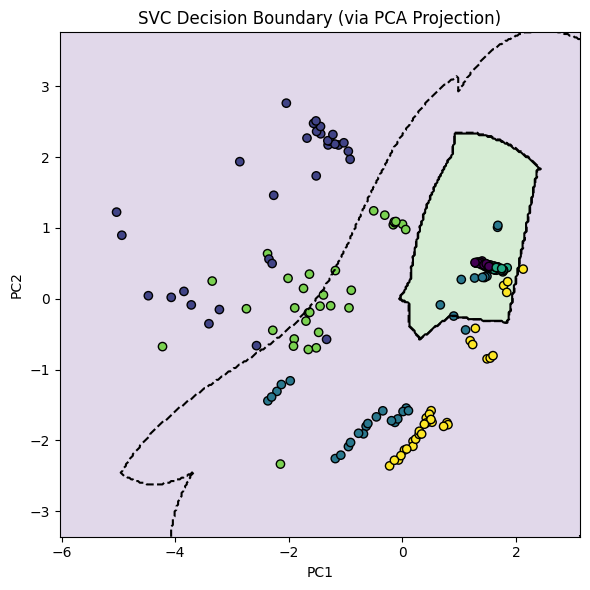

In [22]:
# --- 4. PCA down to 2 components for visualization ---
pca = PCA(n_components=2)
Z_train = pca.fit_transform(X_train)
Z_test  = pca.transform(X_test)

# --- 5. Build meshgrid in PCA space ---
x_min, x_max = Z_train[:,0].min() - 1, Z_train[:,0].max() + 1
y_min, y_max = Z_train[:,1].min() - 1, Z_train[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

# Map the grid back to original 6-D space before decision_function:
grid_2d = np.c_[xx.ravel(), yy.ravel()]           # in PCA space
grid_6d = pca.inverse_transform(grid_2d)           # back to 6-D scaled features

# --- 6. Evaluate and reshape ---
Z = clf_svm.predict(grid_6d)
Z = Z.reshape(xx.shape)

# --- 7. Plot ---
plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z>0, alpha=0.2, levels=[-1,0,1], cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, levels=[-1,0,1], linestyles=['--','-','--'], colors='k')
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train, edgecolors='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('SVC Decision Boundary (via PCA Projection)')
plt.tight_layout()
plt.show()